'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


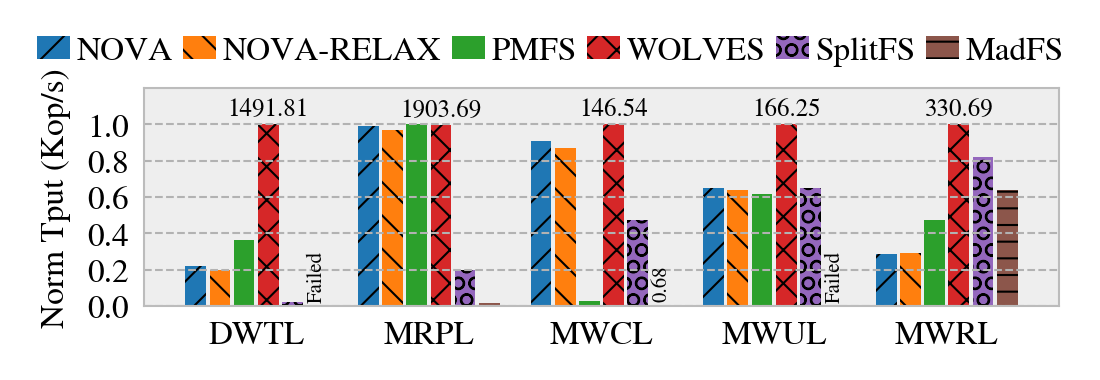

In [15]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('bmh')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams['grid.linestyle'] = "--"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
df_orig = df.copy()
df.drop(df[df['file_system'] == "PMM"].index, inplace=True)

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(2.5)))
bar_width = 0.1
# subfig_titles = ["Normalized Tput to PM"]
patterns = ['///', '\\\\\\', '', 'XXX', 'OOO', '---', '+++']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#2b2d42", "#8d99ae", "#edf2f4", "#ef233c", "#ef233c", "#ef233c", "#ef233c", "#ef233c",]
cmap = "tab10"
bar_width = 0.14
true_bar_width = 0.12

fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
ops = ["DWTL", "MRPL", "MWCL", "MWUL", "MWRL"]
tot = len(fss) * bar_width
x = list(range(1, len(ops) + 1))

max_bws = []
for op_idx, op in enumerate(ops):
    # df[(df['threads'] == 1)][time] = df[(df['threads'] == 1)][time] / df[time].max()
    # print(df[(df['threads'] == 1)][time])
    max_bws.append(df[(df['workload'] == op)]['tput(works/sec)'].max())
    df.loc[(df['workload'] == op), 'tput(works/sec)'] = df[(df['workload'] == op)]['tput(works/sec)'] / max_bws[op_idx]

for idx, fs in enumerate(fss):
    points = []
    for pivot in x:
        point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
        points.append(point)
    bws = []
    bws_abs = []
    for op in ops:
        bws.append(df[(df['file_system'] == fs) & (df['workload'] == op)]['tput(works/sec)'].iloc[0])
        bws_abs.append(df_orig[(df_orig['file_system'] == fs) & (df_orig['workload'] == op)]['tput(works/sec)'].iloc[0])
    # if idx == 0:
    color_idx = idx
    # else:
    #     color_idx = idx + 1
    plt.bar(points, bws, width=true_bar_width, hatch=patterns[color_idx], color=plt.get_cmap(cmap)(color_idx), linewidth=0.5)
    if fs == "KILLER":
        # text
        for i, txt in enumerate(bws):
            plt.text(points[i], bws[i] + 0.05, "{:.2f}".format(bws_abs[i] / 1000), fontsize=6, ha='center')
    
    if fs == "MadFS":
        for i, bw in enumerate(bws):
            if bw == 0:
                plt.text(points[i], bws[i] + 0.05, "Failed", fontsize=5, ha='center', rotation=90)
            elif bws_abs[i] / 1000 < 1:
                plt.text(points[i], bws[i] + 0.05, "{:.2f}".format(bws_abs[i] / 1000), fontsize=5, ha='center',  rotation=90)
    
    
# Draw title
plt.xticks(x, labels=ops, fontsize=8)
# plt.xlabel(subfig_titles[df_idx], fontsize=8) 
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
# if (df_idx == 0):
plt.ylabel('Norm Tput (Kop/s)', fontsize=8)
ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)

# plt.xlabel("Five Common FxMark Metadata Workloads", fontsize=8)  

# legend_labels = ["PMM"]
legend_labels = fss
# legend_labels.extend(fss[:-1]) 
legend_labels = legend_labels.replace("SplitFS-FIO", "SplitFS")
legend_labels = legend_labels.replace("KILLER", "WOLVES")
# legend_labels = legend_labels.replace("KILLER", "KILLER")
# fig.legend(legend_labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=6, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1.5, borderpad=0.2, labelspacing=0.2)
fig.legend(legend_labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2), frameon=False, columnspacing=0.3, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=8)
plt.tight_layout(pad=0.4)
plt.savefig("./FIG-Meta.pdf", bbox_inches='tight', pad_inches=0)